**This notebook is an exercise in the [Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/cross-validation).**

---


In this exercise, you will leverage what you've learned to tune a machine learning model with **cross-validation**.

# Setup

The questions below will give you feedback on your work. Run the following cell to set up the feedback system.

In [1]:
# Set up code checking
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 
from learntools.core import binder
binder.bind(globals())
from learntools.ml_intermediate.ex5 import *
print("Setup Complete")

Setup Complete


You will work with the [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course) from the previous exercise. 

![Ames Housing dataset image](https://storage.googleapis.com/kaggle-media/learn/images/lTJVG4e.png)

Run the next code cell without changes to load the training and test data in `X` and `X_test`.  For simplicity, we drop categorical variables.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('../input/train.csv', index_col='Id')
test_data = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

Use the next code cell to print the first several rows of the data.

In [4]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


So far, you've learned how to build pipelines with scikit-learn.  For instance, the pipeline below will use [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace missing values in the data, before using [`RandomForestRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to train a random forest model to make predictions.  We set the number of trees in the random forest model with the `n_estimators` parameter, and setting `random_state` ensures reproducibility.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

You have also learned how to use pipelines in cross-validation.  The code below uses the [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function to obtain the mean absolute error (MAE), averaged across five different folds.  Recall we set the number of folds with the `cv` parameter.

In [6]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Average MAE score:", scores.mean())

Average MAE score: 18276.410356164386


# Step 1: Write a useful function

In this exercise, you'll use cross-validation to select parameters for a machine learning model.

Begin by writing a function `get_score()` that reports the average (over three cross-validation folds) MAE of a machine learning pipeline that uses:
- the data in `X` and `y` to create folds,
- `SimpleImputer()` (with all parameters left as default) to replace missing values, and
- `RandomForestRegressor()` (with `random_state=0`) to fit a random forest model.

The `n_estimators` parameter supplied to `get_score()` is used when setting the number of trees in the random forest model.  

In [7]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import cross_val_score

    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators=n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')

    return scores.mean()

# Check your answer
step_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#step_1.hint()
#step_1.solution()

# Step 2: Test different parameter values

Now, you will use the function that you defined in Step 1 to evaluate the model performance corresponding to eight different values for the number of trees in the random forest: 50, 100, 150, ..., 300, 350, 400.

Store your results in a Python dictionary `results`, where `results[i]` is the average MAE returned by `get_score(i)`.

In [8]:
results = dict()
#for i in range(50, 450, 50):
#    results[i] = get_score(i)

# Check your answer
step_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#step_2.hint()
#step_2.solution()

Use the next cell to visualize your results from Step 2.  Run the code without changes.

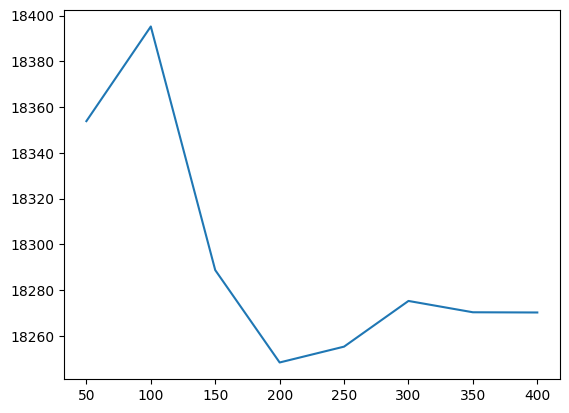

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

# Step 3: Find the best parameter value

Given the results, which value for `n_estimators` seems best for the random forest model?  Use your answer to set the value of `n_estimators_best`.

In [10]:
n_estimators_best = 200

# Check your answer
step_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#step_3.hint()
#step_3.solution()

In this exercise, you have explored one method for choosing appropriate parameters in a machine learning model.  

If you'd like to learn more about [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization), you're encouraged to start with **grid search**, which is a straightforward method for determining the best _combination_ of parameters for a machine learning model.  Thankfully, scikit-learn also contains a built-in function [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) that can make your grid search code very efficient!

# Keep going

Continue to learn about **[gradient boosting](https://www.kaggle.com/alexisbcook/xgboost)**, a powerful technique that achieves state-of-the-art results on a variety of datasets.

In [1]:
def get_score(n_estimators, preprocessor):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.model_selection import cross_val_score

    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)
    
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')

    return scores.mean()



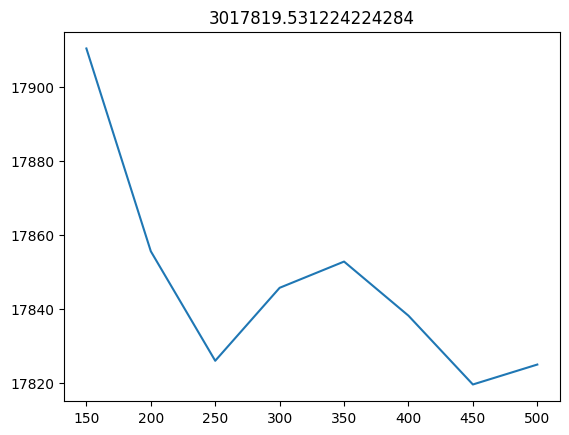

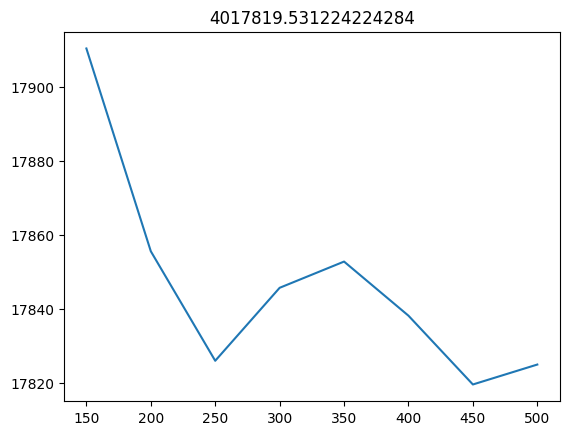

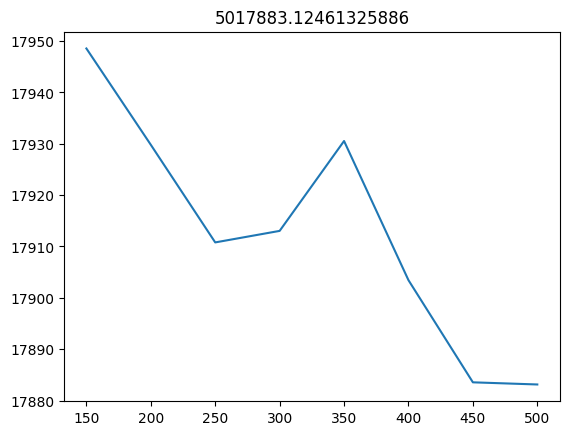

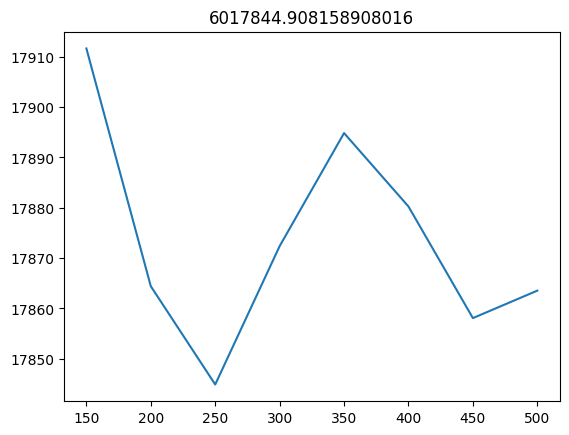

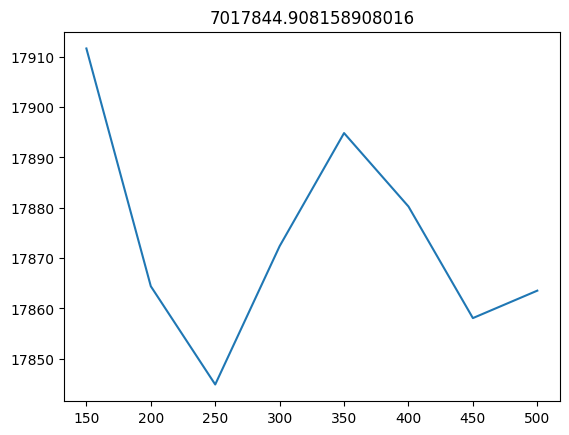

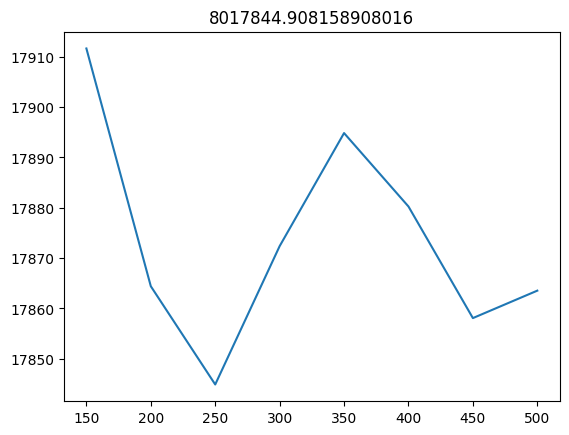

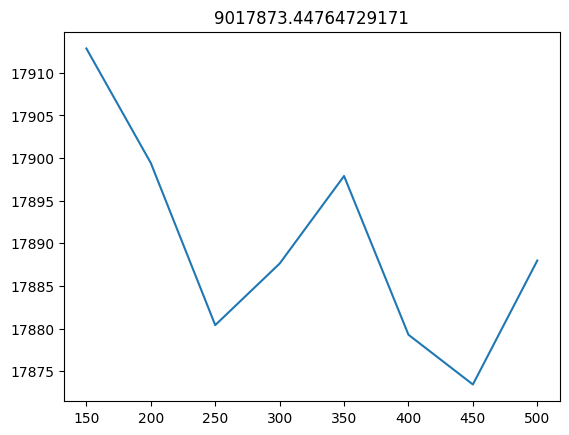

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

for max_porc in range(30, 100, 10):
    # Read the data
    X = pd.read_csv('../input/train.csv', index_col='Id')
    X_test = pd.read_csv('../input/test.csv', index_col='Id')

    #Remove cols with many nulls
    nulls_porc = X.isna().mean()
    cols_with_many_nulls = nulls_porc[nulls_porc > max_porc/100].index
    X.drop(columns=cols_with_many_nulls, inplace=True)
    X_test.drop(columns=cols_with_many_nulls, inplace=True)

    # Remove rows with missing target, separate target from predictors
    X.dropna(axis=0, subset=['SalePrice'], inplace=True)
    y = X.SalePrice              
    X.drop(['SalePrice'], axis=1, inplace=True)

    # Select numeric columns only
    numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
    categorical_cols = [cname for cname in X.columns if X[cname].dtype not in ['int64', 'float64']]

    numerical_transformer = SimpleImputer(strategy='median')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    results = dict()
    for i in range(150, 600, 50):
        results[i] = get_score(i, preprocessor)

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.plot(list(results.keys()), list(results.values()))
    plt.title(str(max_porc) + " - " + str(min(list(results.values()))))
    plt.show()

In [56]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Read the data
X = pd.read_csv('../input/train.csv', index_col='Id')
X_test = pd.read_csv('../input/test.csv', index_col='Id')

#Remove cols with many nulls
nulls_porc = X.isna().mean()
cols_with_many_nulls = nulls_porc[nulls_porc > 0.4].index
X.drop(columns=cols_with_many_nulls, inplace=True)
X_test.drop(columns=cols_with_many_nulls, inplace=True)

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype not in ['int64', 'float64']]

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestRegressor(n_estimators=450, random_state=0)

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

my_pipeline.fit(X, y)
preds_test = my_pipeline.predict(X_test)
output = pd.DataFrame({'Id': X_test.index,
                        'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intermediate-machine-learning/discussion) to chat with other learners.*